In [1]:
import pandas as pd 
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly import subplots
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV,train_test_split, RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('train.csv')
data.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


### Xử lý null

In [5]:
data.isnull().sum().sort_values(ascending = False)

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
data['Gender'] = data['Gender'].fillna(data['Gender'].dropna().mode().values[0])
data['Married'] = data['Married'].fillna(data['Married'].dropna().mode().values[0])
data['Dependents'] = data['Dependents'].fillna(data['Dependents'].dropna().mode().values[0])
data['Self_Employed'] = data['Self_Employed'].fillna(data['Self_Employed'].dropna().mode().values[0])
data['LoanAmount'] = data['LoanAmount'].fillna(data['LoanAmount'].dropna().mode().values[0])
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].dropna().mode().values[0])
data['Credit_History'] = data['Credit_History'].fillna(data['Credit_History'].dropna().mode().values[0])

<Axes: >

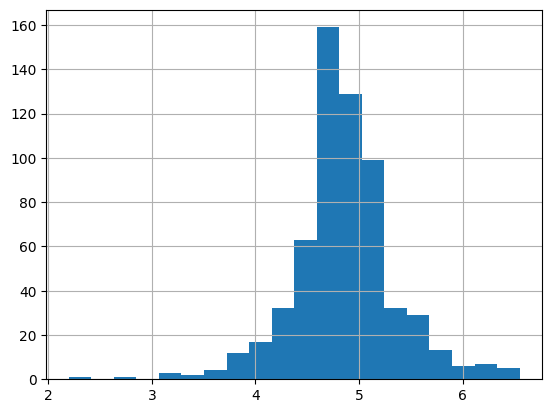

In [7]:
data['loanAmount_log'] = np.log(data['LoanAmount'])
data['loanAmount_log'].hist(bins=20)

In [8]:
data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
loanAmount_log       0
dtype: int64

In [9]:
data.duplicated().sum()

0

### EDA

<Axes: >

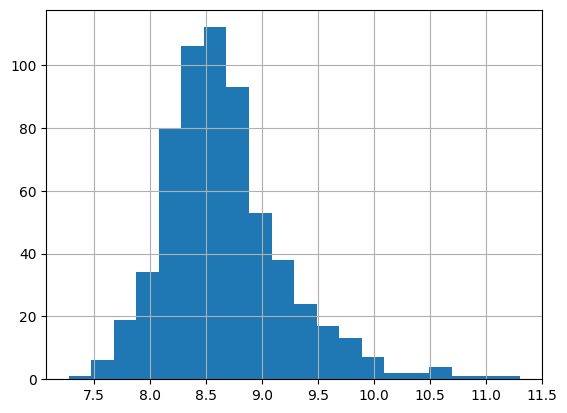

In [10]:
data['TotalIncome'] = data["ApplicantIncome"] + data['CoapplicantIncome']
data['TotalIncome']
data['TotalIncome_log'] = np.log(data['TotalIncome'])
data['TotalIncome_log'].hist(bins = 20)

In [11]:
x = data.iloc[:,np.r_[1:5,9:11,13:15]].values
y = data.iloc[:12].values
x

array([['Male', 'No', '0', ..., 1.0, 4.787491742782046, 5849.0],
       ['Male', 'Yes', '1', ..., 1.0, 4.852030263919617, 6091.0],
       ['Male', 'Yes', '0', ..., 1.0, 4.189654742026425, 3000.0],
       ...,
       ['Male', 'Yes', '1', ..., 1.0, 5.53338948872752, 8312.0],
       ['Male', 'Yes', '2', ..., 1.0, 5.231108616854587, 7583.0],
       ['Female', 'No', '0', ..., 0.0, 4.890349128221754, 4583.0]],
      dtype=object)

In [12]:
print('per of mising gender is %2f%%' %((data['Gender'].isnull().sum()/data.shape[0])*100))

per of mising gender is 0.000000%


<Axes: xlabel='Gender', ylabel='count'>

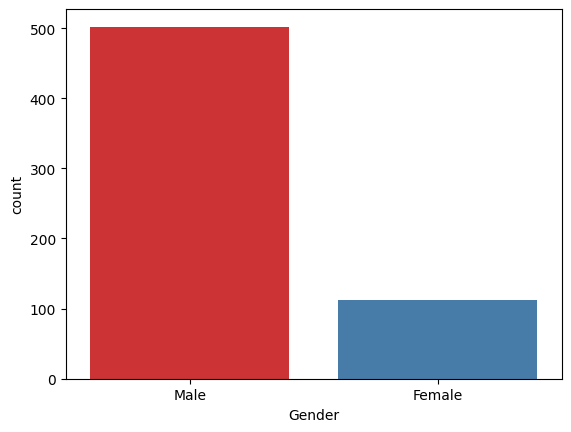

In [13]:
data['Gender'].value_counts()
sns.countplot(x = 'Gender', data = data, palette = 'Set1')

Married
Yes    401
No     213
Name: count, dtype: int64


<Axes: xlabel='Married', ylabel='count'>

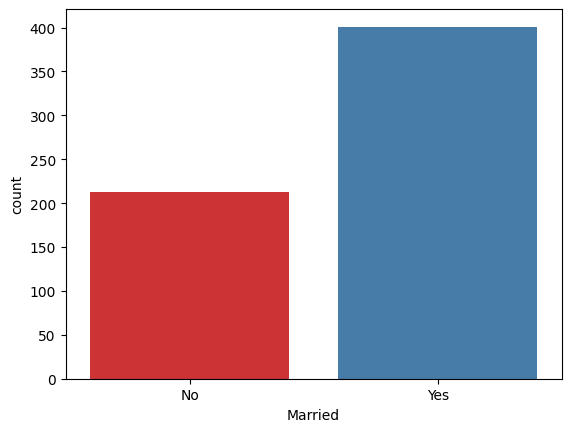

In [14]:
print(data['Married'].value_counts())
sns.countplot(x = 'Married', data = data, palette = 'Set1')

Dependents
0     360
1     102
2     101
3+     51
Name: count, dtype: int64


<Axes: xlabel='Dependents', ylabel='count'>

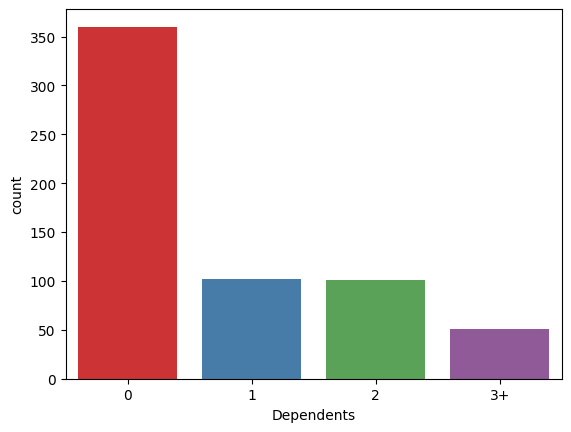

In [15]:
print(data['Dependents'].value_counts())
sns.countplot(x = 'Dependents', data = data, palette = 'Set1')

Self_Employed
No     532
Yes     82
Name: count, dtype: int64


<Axes: xlabel='Self_Employed', ylabel='count'>

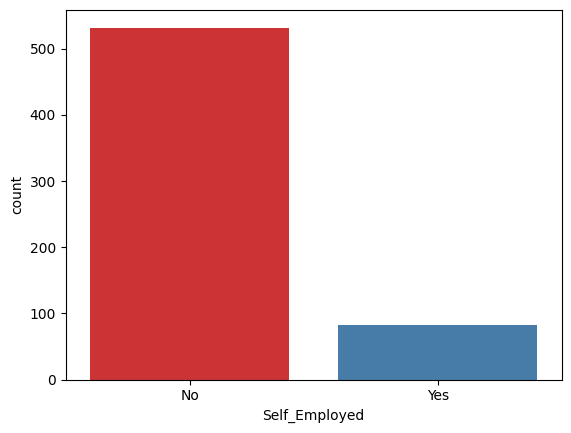

In [16]:
print(data['Self_Employed'].value_counts())
sns.countplot(x = 'Self_Employed', data = data, palette = 'Set1')

LoanAmount
120.0    42
110.0    17
100.0    15
160.0    12
187.0    12
         ..
240.0     1
214.0     1
59.0      1
166.0     1
253.0     1
Name: count, Length: 203, dtype: int64


<Axes: xlabel='LoanAmount', ylabel='count'>

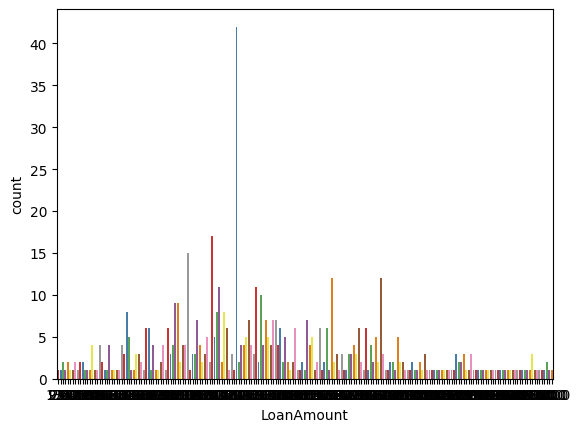

In [17]:
print(data['LoanAmount'].value_counts())
sns.countplot(x = 'LoanAmount', data = data, palette = 'Set1')

Credit_History
1.0    525
0.0     89
Name: count, dtype: int64


<Axes: xlabel='Credit_History', ylabel='count'>

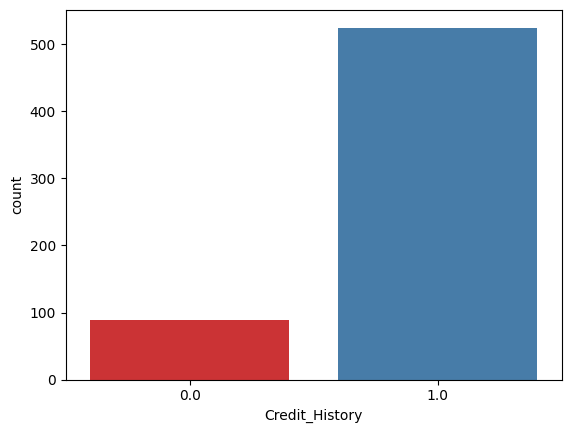

In [18]:
print(data['Credit_History'].value_counts())
sns.countplot(x = 'Credit_History', data = data, palette = 'Set1')

In [19]:
data.Loan_Status.value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

Text(0, 0.5, 'Number of employees')

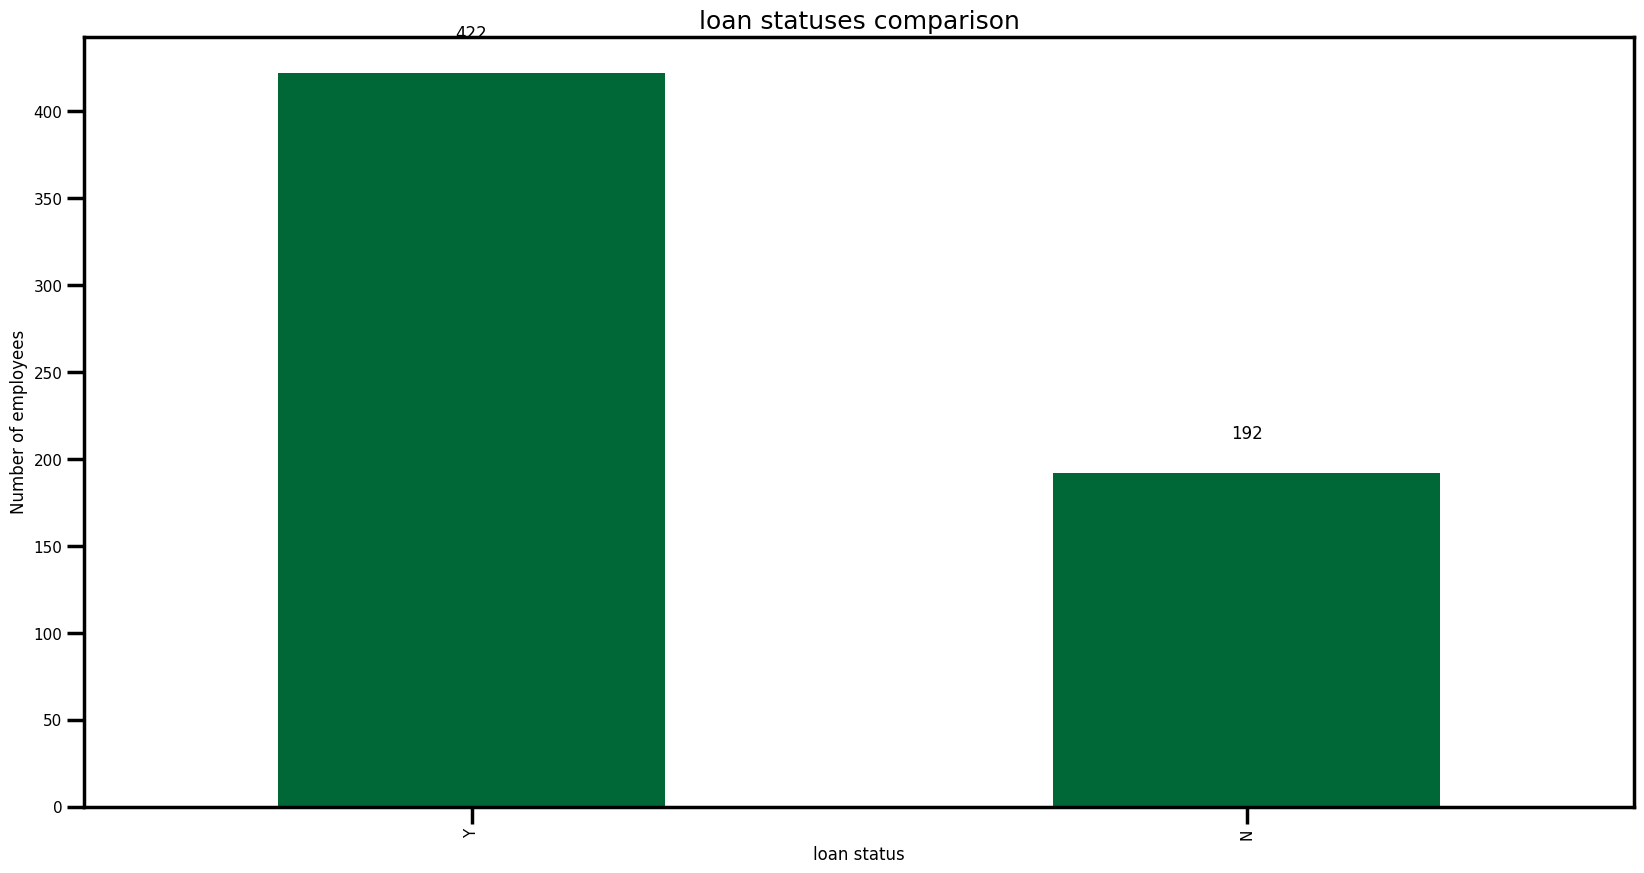

In [20]:
sns.set_context('poster',font_scale=0.5)
plt.figure(figsize=(20,10))
ax = data.Loan_Status.value_counts().plot(kind='bar', cmap='RdYlGn_r')

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+20), ha='center', color='black')

plt.title('loan statuses comparison', fontsize=18)
plt.xlabel('loan status')
plt.ylabel('Number of employees')

<Figure size 2000x1000 with 0 Axes>

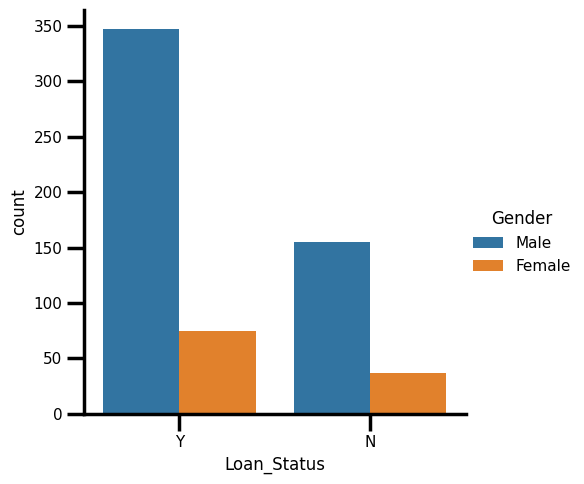

In [21]:
plt.figure(figsize=(20,10))
sns.catplot(x='Loan_Status', hue='Gender',kind='count', data=data)

In [22]:
data.groupby('Gender')['Loan_Status'].value_counts(normalize=True)

Gender  Loan_Status
Female  Y              0.669643
        N              0.330357
Male    Y              0.691235
        N              0.308765
Name: proportion, dtype: float64

<Axes: xlabel='Education', ylabel='count'>

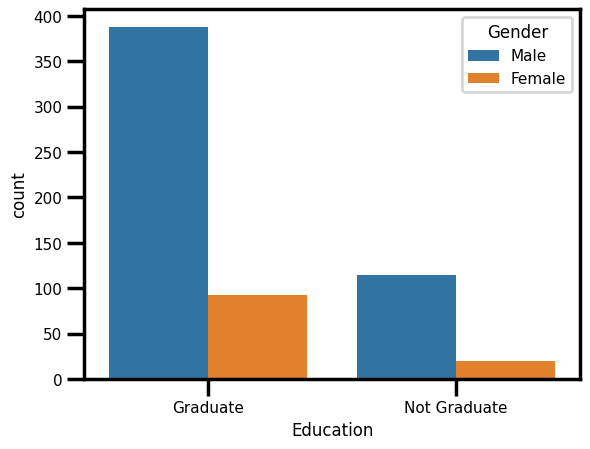

In [23]:
sns.countplot(x='Education',hue='Gender',data=data)

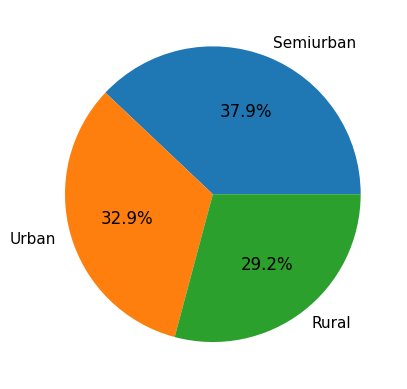

In [24]:
s=data['Property_Area'].value_counts()/data['Property_Area'].value_counts().sum()*100
plt.pie(s.values,labels=s.index,autopct='%1.1f%%')
plt.show()

### Train model

In [25]:
print(set(data['Gender'].values.tolist()))
print(set(data['Dependents'].values.tolist()))
print(set(data['Married'].values.tolist()))
print(set(data['Education'].values.tolist()))
print(set(data['Self_Employed'].values.tolist()))
print(set(data['Loan_Status'].values.tolist()))
print(set(data['Property_Area'].values.tolist()))

{'Male', 'Female'}
{'3+', '0', '2', '1'}
{'No', 'Yes'}
{'Graduate', 'Not Graduate'}
{'No', 'Yes'}
{'Y', 'N'}
{'Urban', 'Semiurban', 'Rural'}


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
 13  loanAmount_log     614 non-null    float64
 14  TotalIncome        614 non-null    float64
 15  TotalIncome_log    614 non-null    float64
dtypes: float64(7), int64(1), o

In [27]:
data['Loan_Status'] = data['Loan_Status'].map({'N' : 0, 'Y' : 1}).astype(int)
data = pd.get_dummies(data, columns = ['Gender', 'Dependents', 'Married', 'Education', 'Self_Employed', 'Property_Area'])

In [28]:
standardScaler = StandardScaler()
columns_to_scale = ['ApplicantIncome','CoapplicantIncome','LoanAmount', 'Loan_Amount_Term']
data[columns_to_scale] = standardScaler.fit_transform(data[columns_to_scale])

In [29]:
y = data['Loan_Status']
X = data.drop(['Loan_Status', 'Loan_ID'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

Training Machine Learning (ML) Models for Loan Prediction

### Xgboost

In [30]:
gbm_param_grid = {
    'n_estimators' : range(1,1000,10),
    'max_depth' : range(1,20),
    'learning_rate' : [.1, .4, .45, .5, .55, .6],
    'colsample_bytree' : [.6, .7, .8, .9, 1],
}

xgb_classifier = XGBClassifier()
xgb_random = RandomizedSearchCV(param_distributions = gbm_param_grid, estimator = xgb_classifier, scoring = 'accuracy', verbose = 0, n_iter =100, cv = 4)
xgb_random.fit(X_train, y_train)
print(f'Best parameters: {xgb_random.best_params_}')
y_pred = xgb_random.predict(X_test)
print(f'Accuracy: {np.sum(y_pred == y_test)/len(y_test)}')

Best parameters: {'n_estimators': 61, 'max_depth': 1, 'learning_rate': 0.5, 'colsample_bytree': 0.7}
Accuracy: 0.7886178861788617


# Decision Tree

In [35]:
param_grid = {
    'max_depth' : range(4,25),
    'min_samples_leaf' : range(10,100,10),
    'criterion' : ['gini','entropy']
}
n_folds = 5

dt = DecisionTreeClassifier(random_state=np.random.randint(0,100))
dt_grip = GridSearchCV(dt, param_grid, cv = n_folds, return_train_score= True, verbose=0)
dt_grip.fit(X_train,y_train)
print(dt_grip.best_params_)

y_pred_best = dt_grip.predict(X_test)
acc=metrics.accuracy_score(y_test,y_pred_best)
print(acc)

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 30}
0.7886178861788617


In [33]:
svm_param_grid = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'C':range(1,11)
}
svm=SVC()
svm_random = RandomizedSearchCV(param_distributions= svm_param_grid,
                                estimator=svm, scoring='accuracy',
                                verbose=0, n_iter=100, cv=4)
svm_random.fit(X_train, y_train)
best_params = svm_random.best_params_

y_pred_best = svm_random.predict(X_test)
acc = metrics.accuracy_score(y_test, y_pred_best)
print(acc)

0.7642276422764228


In [32]:
rf_param_grid = {
    'n_estimators' : range(1,1000,100),
}
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(param_distributions=rf_param_grid,
                               estimator=rf, scoring="accuracy",
                               verbose= 0, n_iter= 100, cv= 4)
rf_random.fit(X_train, y_train)
best_params = rf_random.best_params_
print(f'Best parameters: {best_params}')

y_pred1 = rf_random.predict(X_test)
print(f'Accuracy: {np.sum(y_pred1==y_test)/len(y_test)}')


Best parameters: {'n_estimators': 901}
Accuracy: 0.7886178861788617


In [43]:
def feature_imp(df, model):
    feat = pd.DataFrame(columns=['feature','importance'])
    feat['feature'] = df.columns
    feat['importance'] = model.best_estimator_.feature_importances_
    return feat.sort_values(by='importance', ascending = False)

<Axes: ylabel='feature'>

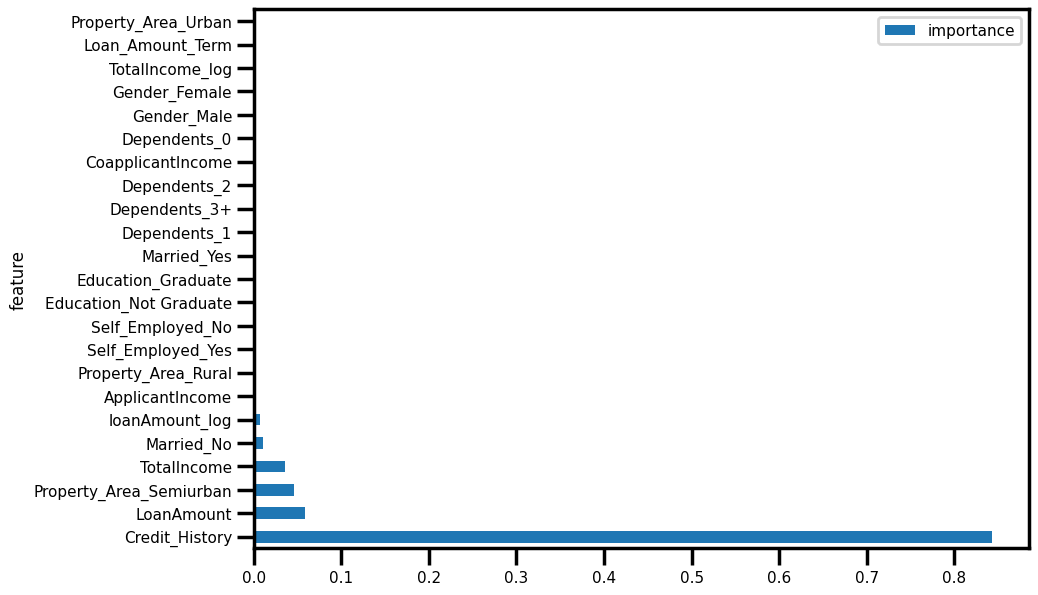

In [47]:
feature_imp(X_train,dt_grip).plot('feature', 'importance','barh',
                                   figsize=(10,7))

<Axes: ylabel='feature'>

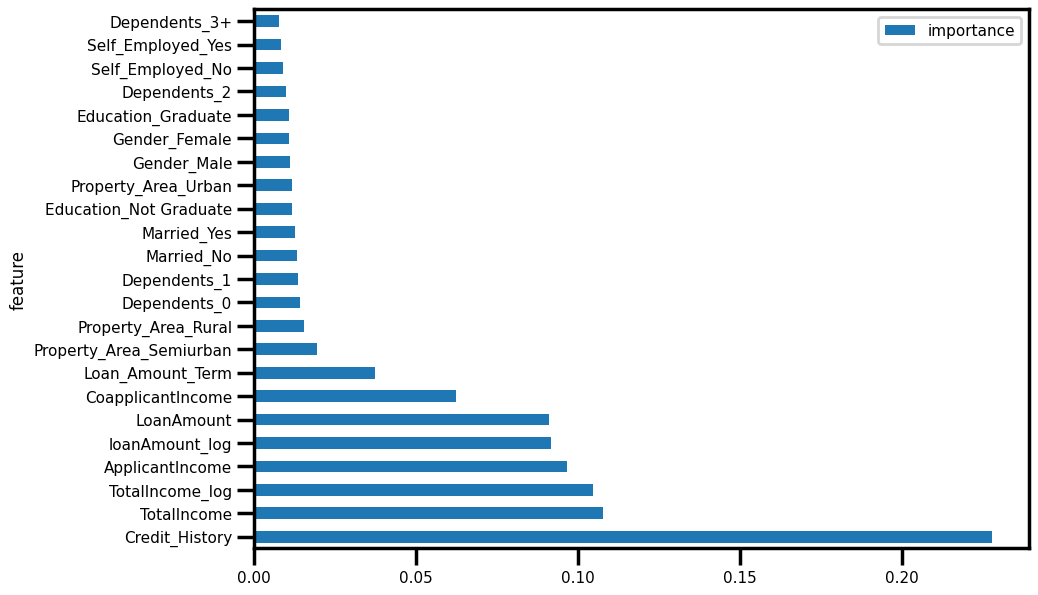

In [48]:
feature_imp(X_train,rf_random).plot('feature', 'importance','barh',
                                   figsize=(10,7))

<Axes: ylabel='feature'>

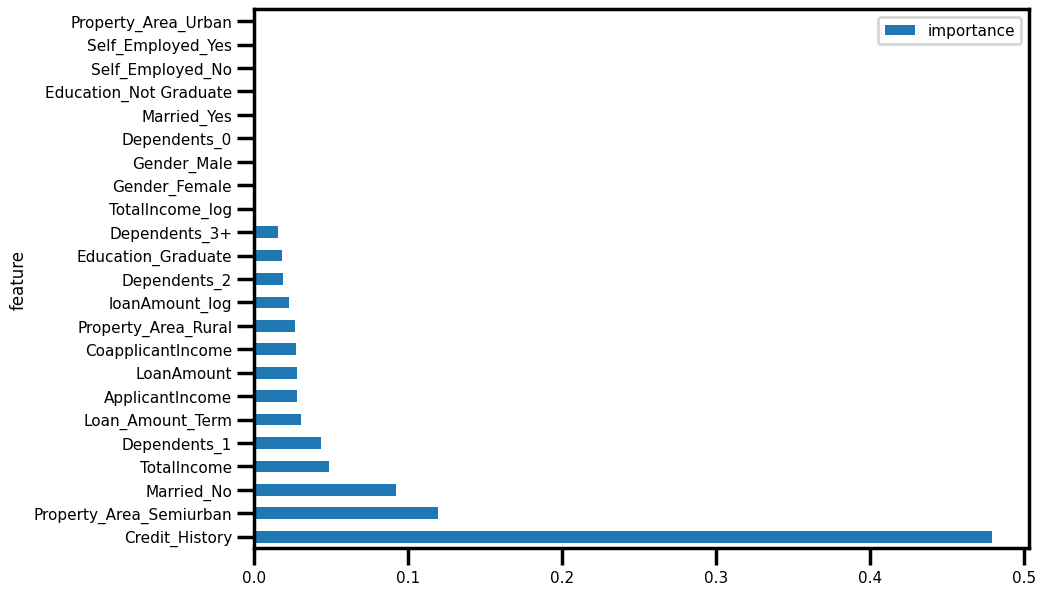

In [50]:
feature_imp(X_train,xgb_random).plot('feature', 'importance','barh',
                                   figsize=(10,7))